In [1]:
import numpy as np
import pandas as pd
import sqlite3
import pingouin as pg
from scipy.stats import chi2_contingency
import seaborn as sns

In [2]:
#raw_tables
prior = pd.read_csv("prior.csv")

con = sqlite3.connect("myDB.db")
user = pd.read_sql_query("SELECT * from user", con)
answer = pd.read_sql_query("SELECT * from answers", con)
con.close()

user['time_hash'] = user['time_hash'].astype(int)
answer['task_time'] = (pd.to_datetime(answer.end_time) - pd.to_datetime(answer.start_time))/np.timedelta64(1,'s')

data = pd.merge(user,answer,left_on='time_hash',right_on='user_hid')
numbers = data[['id_x','username','group','block_num','task_num','answer','task_time',
                'how_helpful','how_comfortable']].dropna()
words = user[['id','username','group','reason']].dropna()

In [ ]:
#task_tables
def table_maker(task_num_block0, task_num_block1, check_string):
    block0_task = numbers.loc[(numbers.block_num == 0) & (numbers.task_num ==task_num_block0), 
                       ['id_x','username','group','answer', 'task_time','how_helpful','how_comfortable']]
    block1_task = numbers.loc[(numbers.block_num == 1) & (numbers.task_num ==task_num_block1), 
                       ['id_x','username','group','answer', 'task_time','how_helpful','how_comfortable']]
    
    table_task = pd.merge(block0_task, block1_task, on=['id_x', 'username','group','how_helpful','how_comfortable'])
    table_task['delta_time'] = table_task.task_time_y-table_task.task_time_x
    table_task['change'] = (table_task.answer_x.str.contains(check_string, regex=False)!=
                             table_task.answer_y.str.contains(check_string, regex=False)) 
    table_task.loc[table_task.answer_x.str.contains(check_string, regex=False), 'change'] = 'No_set'
    table_task = pd.merge(prior,table_task, on='username')
    table_task.loc[~(table_task.set.str.contains(check_string, regex=False)), 'change'] = 'No_preset'
    table_task = table_task.loc[: , ['id_x', 'username', 'set', 'group', 'answer_x' , 
                                     'task_time_x', 'answer_y' , 'task_time_y', 
                                     'delta_time', 'change', 'how_helpful', 'how_comfortable']]
    return table_task

lambda_table = table_maker(3, 2, check_string ='lambda')
isinstance_table = table_maker(0, 1, check_string ='isinstance')
enumerate_table = table_maker(1, 0, check_string ='enumerate')
sum_table = table_maker(2, 3, check_string ='sum(')

In [ ]:
#pre_analysis_tables
def no_preset_table(table_name):
    no_preset_table = table_name.loc[table_name.change.str.contains('No_preset', na=False), 
                                     ['id_x', 'group', 'answer_x', 'answer_y', 'delta_time', 
                                      'how_helpful','how_comfortable']]
    return no_preset_table

def no_set_table(table_name):
    no_set_table = table_name.loc[table_name.change.str.contains('No_set', na=False), 
                                     ['id_x', 'group', 'answer_x', 'answer_y', 'delta_time',
                                      'how_helpful','how_comfortable']]
    return no_set_table

def is_change_table(table_name):
    is_change_table = table_name.loc[(table_name.change.isin([True, False])), 
                                  ['id_x', 'group', 'answer_x', 'answer_y', 'delta_time', 'change', 
                                   'how_helpful','how_comfortable']]
    return is_change_table

In [ ]:
#to_see_the_tables

#lambda_table
#no_preset_table(lambda_table)
#is_change_table(lambda_table)
#no_set_table(lambda_table)

#isinstance_table
#no_preset_table(isinstance_table)
#no_set_table(isinstance_table)
#is_change_table(isinstance_table)

#enumerate_table
#no_preset_table(enumerate_table)
#no_set_table(enumerate_table)
#is_change_table(enumerate_table)

#sum_table
#no_preset_table(sum_table)
#no_set_table(sum_table)
#is_change_table(sum_table)

In [ ]:
#analysis_tables

#dalta_or_change_corr_with_«how»questions
def corr_result(table_name, x, y):
    pcor = pg.partial_corr(data=table_name, x=x, y=y, covar='group').round(3)
    return (pcor)

#for_is_change_table
def chi2_result(table_name):
    data = is_change_table(table_name)
    data_crosstab = pd.crosstab(data.group, data.change)
    return (chi2_contingency(data_crosstab))

#may be used for both no_set_table and no_preset_table
def anova_result(table_name):
    aov = pg.anova(dv='delta_time', between='group', data=table_name, detailed=True)
    return (aov)

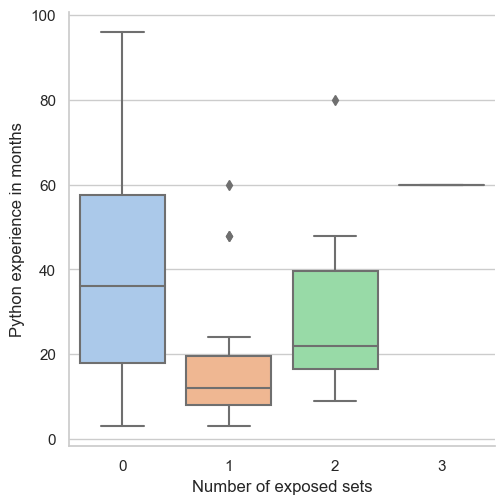

In [30]:
#months_to_number_of_set_corr
sns.set_theme(style="whitegrid", palette="pastel")
ax = sns.catplot(x="set_count", y="months", kind="box",data=prior)
ax.set(ylabel="Python experience in months", xlabel="Number of exposed sets")

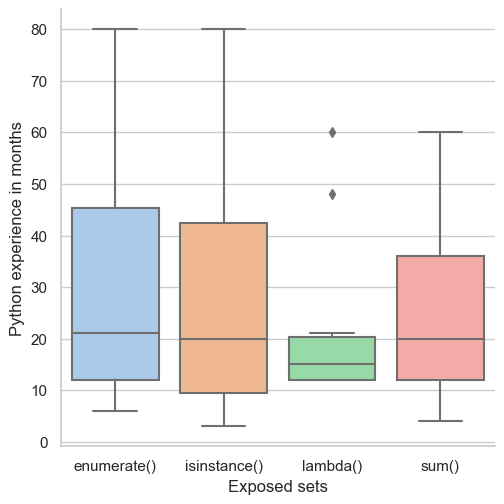

In [43]:
#months_to_types_of_set_corr
df=prior.loc[(prior.exp == 1)]
new_df = pd.DataFrame(df.set.str.split(',').tolist(), index=df.username).stack()
new_df = new_df.reset_index([0, 'username'])
new_df.columns = ['username', 'set']
new_df = pd.merge(df, new_df, on=['username'], )
new_df = new_df.loc[:, ['username', 'months', 'set_count', 'set_y']]

sns.set_theme(style="whitegrid", palette="pastel")
ax = sns.catplot(x="set_y", y="months", data=new_df, kind="box")
ax.set(ylabel="Python experience in months", xlabel="Exposed sets")

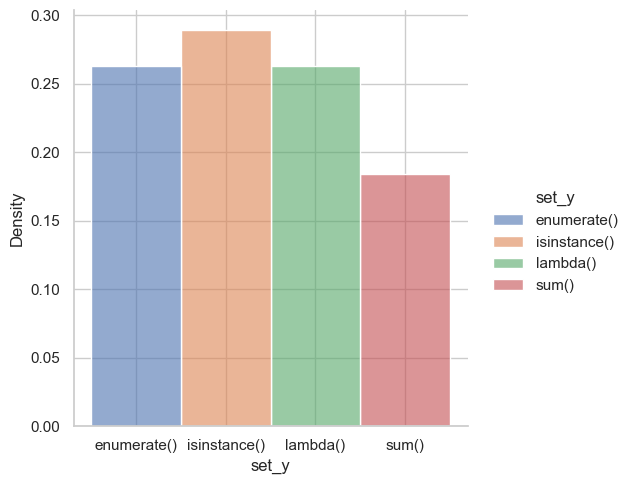

In [52]:
#percentage_of_set_types
sns.set_theme(style="whitegrid")
sns.displot(new_df, x="set_y", hue="set_y", stat="density", alpha=0.6)